In [1]:
import itertools
import numpy as np
import numpy.random as npr
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import colors
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D  

import scipy.io
from scipy.io import loadmat
from scipy.io import savemat
from scipy import stats
from sklearn.metrics import log_loss
import pickle
import copy

%load_ext autoreload
%autoreload 2

In [2]:
subjectNames = ['sam','tabitha','chloe','blanche','b01','b02','b03','b04','b05','b06','b07','b08','b09','b10','WSLS_1']

numSubjects = len(subjectNames)

speciesList = np.array([0,0,0,0,1,1,1,1,1,2,2,2,2,2,3])

species = ['monkeys','humans','humans2','agent']
fNameSuffix = ['Monkey','Human','Human2', 'Agent']

speciesColors = ['#fb8072', '#8dd3c7','#3288bd','#000000']

######################################
trainDat = dict()
testDat = dict()

for s, suff in zip(species, fNameSuffix):
    with open("analysis/"+s+".npz", "rb") as f:
        npzfile = np.load(f)
        trainDat[s] = npzfile['trainLL'+suff]
        testDat[s] = npzfile['testLL'+suff]
        # print(trainDat[s].shape)

trainDat_objPred = dict()
testDat_objPred = dict()

for s, suff in zip(species[:2], fNameSuffix[:2]):
    with open("analysis/"+s+"_objPred.npz", "rb") as f:
        npzfile = np.load(f)
        trainDat_objPred[s] = npzfile['trainLL'+suff]
        testDat_objPred[s] = npzfile['testLL'+suff]
        # print(trainDat[s].shape)


analysis = []
data = []
data0 = []

for i in range(numSubjects):
    with open('analysis/'+subjectNames[i]+'.pickle', 'rb') as f:
        [A] = pickle.load(f)
        # print(A['transitionStats'].keys())
    analysis.append(A)
    with open('data/'+subjectNames[i]+'.pickle', 'rb') as f:
        [D] = pickle.load(f)
    data.append(D)
    data0.append(D)

with open('data/WSLS_feat.pickle','rb') as f:
    [featData] = pickle.load(f)

with open('analysis/objPredSummary.pickle', 'rb') as f:
    [probabilityPredM, probabilityPredH, sigM, sigH] = pickle.load(f)

In [3]:

def getPM(N):
    if N == 1:
        return 1
    elif N > 1:
        x = np.zeros([N])
        x[0] = 1
        for i in np.arange(1,N):
            x[i] = -1 * x[i-1]
        return x


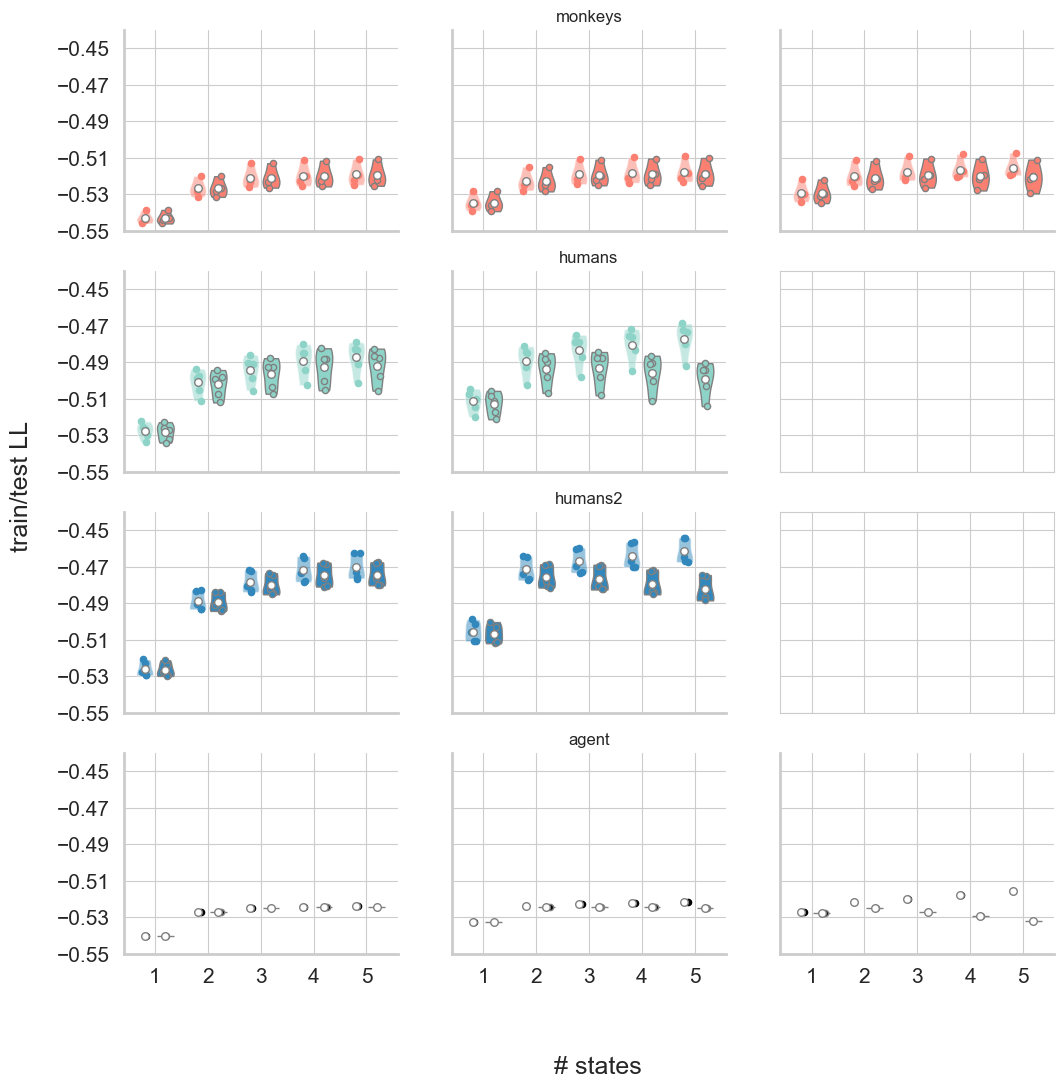

In [4]:
vpWidth = 0.35

fig, ax = plt.subplots(ncols=3,nrows=4,sharex=True,sharey=True,figsize=(3*4,3*4))

fig.text(0.52, 0.01, '# states', ha='center', size=18)
fig.text(0.03, 0.5, 'train/test LL', va='center', rotation='vertical', size=18)

for spInd in range(4): # Monkeys and 2 human datasets
# fig.suptitle('monkey',y=0.92,fontsize=20)

    for lag in range(trainDat[species[spInd]].shape[0]):
        for k in range(5):
            # train
            data1 = trainDat[species[spInd]][lag,:,k]
            x1 = k+1-vpWidth/1.8
            vp1 = ax[spInd, lag].violinplot(data1,[x1],showextrema=False,widths=0.9*vpWidth)
            for pc in vp1['bodies']:
                pc.set_facecolor(speciesColors[spInd])#speciesColor[0])
#                 pc.set_edgecolor('gray')
                pc.set_alpha(0.5)

            x = npr.rand(trainDat[species[spInd]].shape[1]) * (vpWidth) * (0.2)
            pm = getPM(x.shape[0])
            x = np.multiply(x,pm) + x1
            ax[spInd, lag].scatter(x,data1,s=20,color=speciesColors[spInd])#speciesColor[0])

            ax[spInd, lag].scatter(x1,np.mean(data1),color='white',s=30,edgecolors='gray')

            # test
            data2 = testDat[species[spInd]][lag,:,k]
            x2 = k+1+vpWidth/1.8
            vp2 = ax[spInd, lag].violinplot(data2,[x2],showextrema=False,widths=0.9*vpWidth)
            for pc in vp2['bodies']:
                pc.set_facecolor(speciesColors[spInd])
                pc.set_edgecolor('gray')
                pc.set_alpha(1)

            x = npr.rand(trainDat[species[spInd]].shape[1]) * (vpWidth) * (0.2)
            pm = getPM(x.shape[0])
            x = np.multiply(x,pm) + x2
            ax[spInd, lag].scatter(x,data2,s=20,color=speciesColors[spInd],edgecolors='gray')

            ax[spInd, lag].scatter(x2,np.mean(data2),color='white',s=30,edgecolors='gray')

        ax[spInd, lag].set_ylim([-0.55,-0.44])

        ax[spInd, lag].set_axisbelow(True)
        # ax[spInd, lag].grid(which='major', axis='both')
        ax[spInd, lag].tick_params(axis='both',labelsize= 15,direction='in',pad=10)

        ax[spInd, lag].set_xticks(np.arange(5)+1)
        ax[spInd, lag].set_yticks(np.arange(-0.55,-0.44, 0.02))
        # change all spines
        for axis in ['top','bottom','left','right']:
            ax[spInd, lag].spines[axis].set_linewidth(2)

        ax[spInd, lag].spines['right'].set_visible(False)
        ax[spInd, lag].spines['top'].set_visible(False)

        # increase tick width
        ax[spInd, lag].tick_params(width=2)

    ax[spInd, 1].set_title(species[spInd])
# plt.savefig('monkeyFitStats.eps', format='eps')

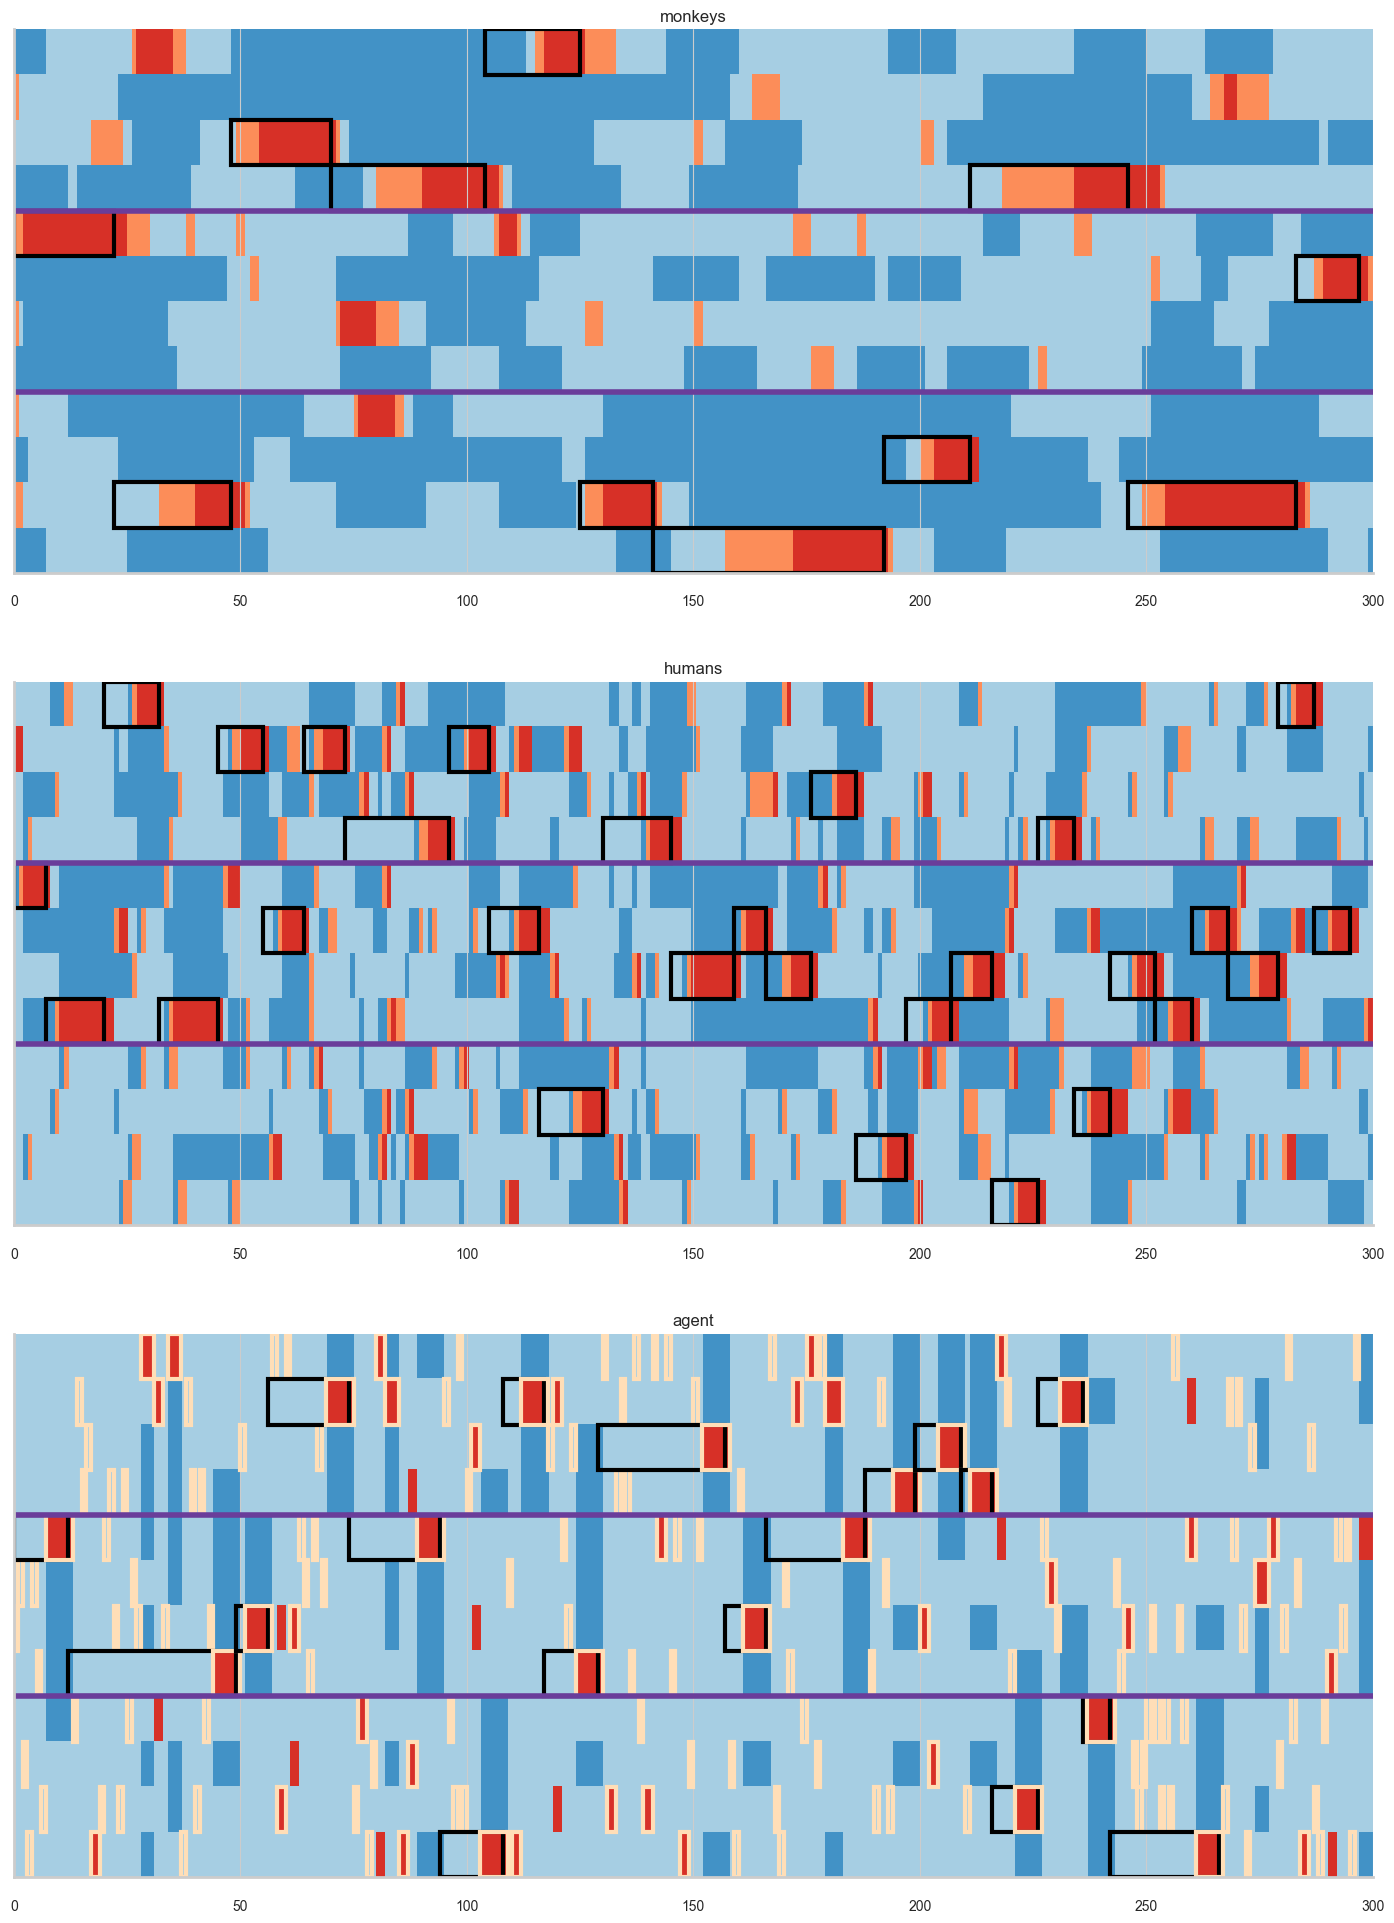

In [5]:

# define color map
color_map = {0: np.array([215,48,39]),
             1: np.array([252,141,89]),
             2: np.array([166,206,227]), #224,243,248
             3: np.array([66,146,198])} #116,173,209

fig, ax = plt.subplots(ncols=1,nrows=3,figsize=(4*2*5,4*2*3))

for spInd in range(3): # Monkeys, first human dataset and WSLS Agent
    if spInd == 0: #monkey
        sp_dInd = 0
        dd = data0[sp_dInd]['superBlocksData']['viterbi'][4][:,:300]
    elif spInd == 1: #human dataset 1
        sp_dInd = 4
        dd = data0[sp_dInd]['superBlocksData']['viterbi'][4][:,:]
    else: # WSLS Agent
        color_map = {0: np.array([215,48,39]),
                     1: np.array([166,206,227]), #224,243,248
                    2: np.array([66,146,198])} #116,173,209
        sp_dInd = 14
        dd = data0[sp_dInd]['superBlocksData']['viterbi'][4][:,:300]


    # make a 3d numpy array that has a color channel dimension
    data_3d = np.ndarray(shape=(dd.shape[0], dd.shape[1], 3), dtype=int)
    for i in range(0, dd.shape[0]):
        for j in range(0, dd.shape[1]):
            data_3d[i][j] = color_map[dd[i][j]]

    ax[spInd].imshow(data_3d,extent=[0,300,0,12], aspect=10)

    cRule = data0[sp_dInd]['superBlocksData']['rule'][4][0]
    st = 0
    ln = 1
    if spInd == 2: # WSLS Agent
        fd = featData[4][:300]
        cRule2 = fd[0]
        st2 = 0
        ln2 = 1
    for i in range(1, min(300, data0[sp_dInd]['superBlocksData']['viterbi'][4].shape[1])):
        if cRule == data0[sp_dInd]['superBlocksData']['rule'][4][i]:
            ln += 1
        else:
            rect = patches.Rectangle((st, 11-cRule), ln, 1, linewidth=3, edgecolor='k', facecolor='none')
            ax[spInd].add_patch(rect)
            st = i
            ln = 1
            cRule = data0[sp_dInd]['superBlocksData']['rule'][4][i]

        if spInd == 2: # WSLS Agent
            if cRule2 == fd[i]: #data0[9]['superBlocksData']['rule'][4][i]:
                ln2 += 1
            else:
                rect = patches.Rectangle((st2, 11-cRule2), ln2, 1, linewidth=3, edgecolor='#ffdeb7', facecolor='none')
                ax[spInd].add_patch(rect)
                st2 = i
                ln2 = 1
                cRule2 = fd[i]


    ax[spInd].plot([0, 300],[8,8],linewidth=4,color='#6a3d9a')
    ax[spInd].plot([0, 300],[4,4],linewidth=4,color='#6a3d9a')
    ax[spInd].tick_params(axis='both',direction='out',width=2, length=12)
    # ax.tick_params(axis='x',length=5,labelsize=18)
    # change all spines
    for axis in ['top','bottom','left','right']:
        ax[spInd].spines[axis].set_linewidth(2)

    ax[spInd].spines['right'].set_visible(False)
    ax[spInd].spines['top'].set_visible(False)

    ax[spInd].set_axisbelow(True)
    # ax.get_xaxis().set_visible(False)
    ax[spInd].get_yaxis().set_visible(False)
    # plt.savefig('exampleMonkeyStates.eps', format='eps')
    if spInd < 2:
        ax[spInd].set_title(species[spInd])
    else:
        ax[spInd].set_title(species[3])

Text(0.5, 0, 'State posterior probability')

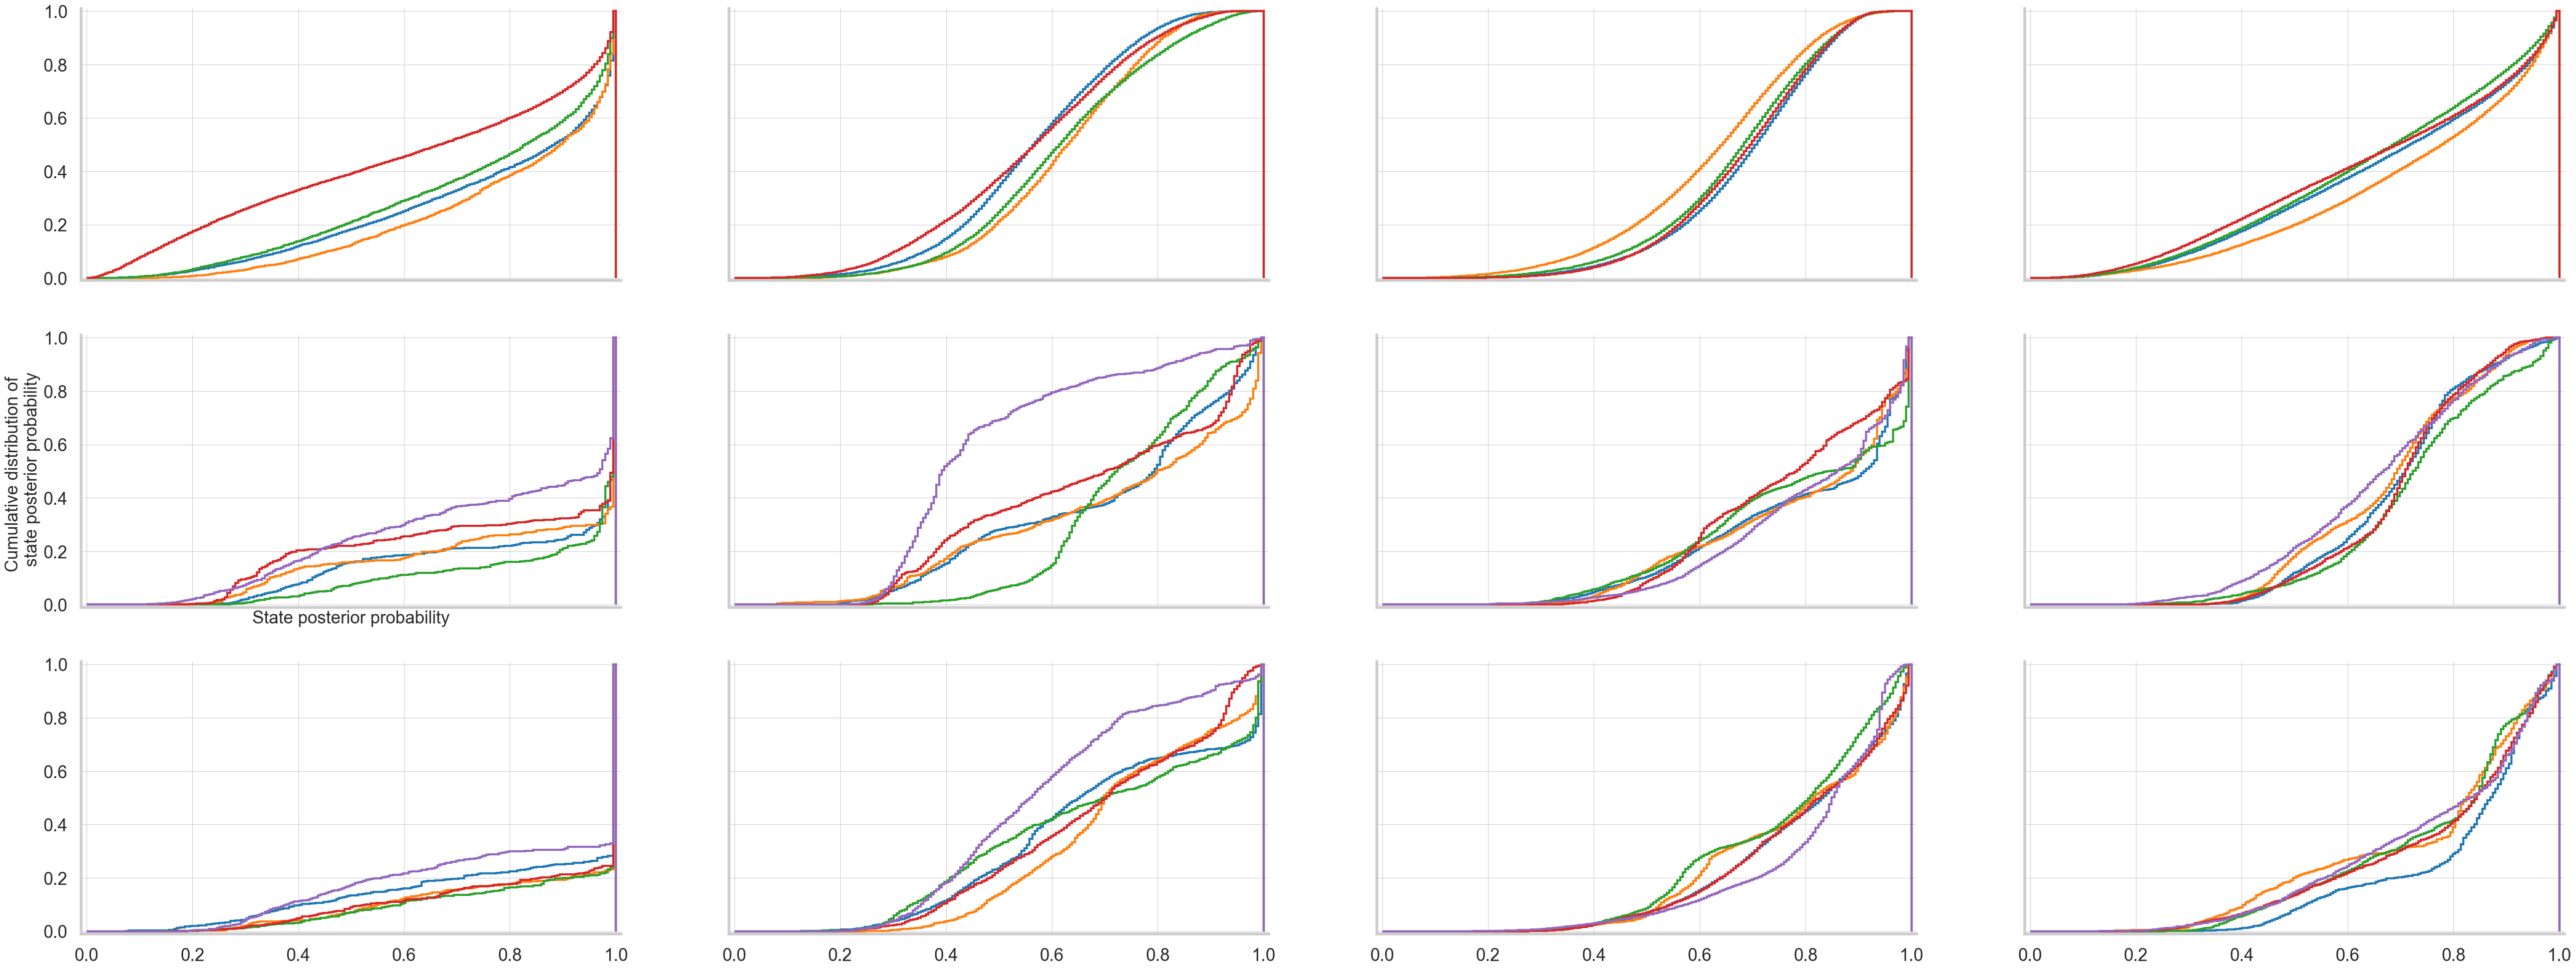

In [6]:

# posterior distributions

fig, ax = plt.subplots(ncols=4,nrows=3,figsize=(4*2*8,4*2*3),sharex=True, sharey = True)

binsX = np.linspace(0, 1, 200)
for i in range(4):
    for j in range(3):
        if j == 0:
            krng = range(4)
        elif j == 1:
            krng = range(4,9)
        else:
            krng = range(9,14)
        for k in krng:
                X = []
                for l in range(len(data0[k]['superBlocksData']['posterior'])):
                    for f in range(12):
                        pInds = np.nonzero(data0[k]['superBlocksData']['viterbi'][l][f,:] == i)
                        dd = np.squeeze(data0[k]['superBlocksData']['posterior'][l][f,pInds,i])
                        if dd.size > 0 and dd.ndim > 0:
                            X.append(dd)
                Y = np.concatenate(X, axis = 0)
                ax[j][i].hist(Y, binsX, weights=np.ones_like(Y)/Y.size, cumulative=True, histtype='step',linewidth=3)

                ax[j][i].tick_params(axis='both',labelsize= 25,direction='out',width=4, length=16)
                # change all spines
                for axis in ['top','bottom','left','right']:
                    ax[j][i].spines[axis].set_linewidth(4)

                ax[j][i].spines['right'].set_visible(False)
                ax[j][i].spines['top'].set_visible(False)
                ax[j][i].set_xlim([-0.01,1.01])
                ax[j][i].set_ylim([-0.01,1.01])

                ax[j][i].set_axisbelow(True)

ax[1][0].set_ylabel('Cumulative distribution of \n state posterior probability',fontsize=25)
ax[1][0].set_xlabel('State posterior probability',fontsize=25)

# plt.savefig('posteriorDistr.eps', format='eps')

No handles with labels found to put in legend.


[0.99964739 0.25225579 0.        ]
[0.98084134 0.25877758 0.01659442]


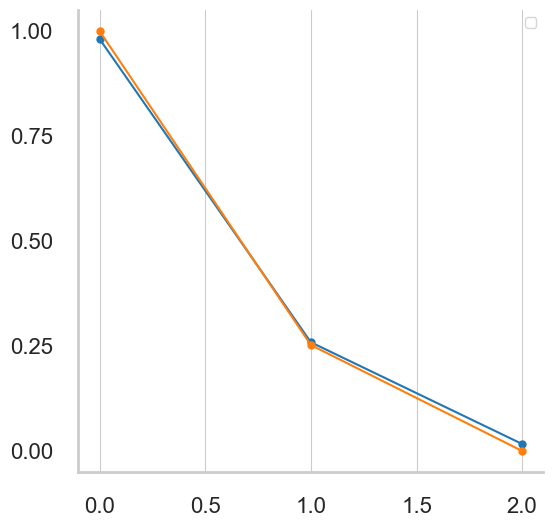

In [7]:

pc_S_mdl = analysis[14]['choiceStats']['pc_S_mdl']
pc_S_emp = analysis[14]['choiceStats']['pc_S_emp']

print(pc_S_emp)
print(pc_S_mdl)

fig, ax = plt.subplots(figsize=(6,6),nrows=1,ncols=1)#,tight_layout=True)

ax.plot(pc_S_mdl,marker='.', markersize=10)
ax.plot(pc_S_emp,marker='.', markersize=10)


ax.set_yticks([0,0.25,0.5,0.75,1])
ax.tick_params(axis='x',labelsize= 16,direction='in',pad=10)
ax.tick_params(axis='y',labelsize= 16,direction='in',pad=10)
# ax.set_xlim([0,120])
# ax.set_ylim([yticks[0],0.55])
ax.legend()

# ax[i].set_ylabel('probability')

# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# increase tick width
ax.tick_params(width=2)
ax.tick_params(direction='out',length=8)

ax.grid(which='major', axis='y')
# plt.savefig('WSLSBest3a.eps', format='eps')

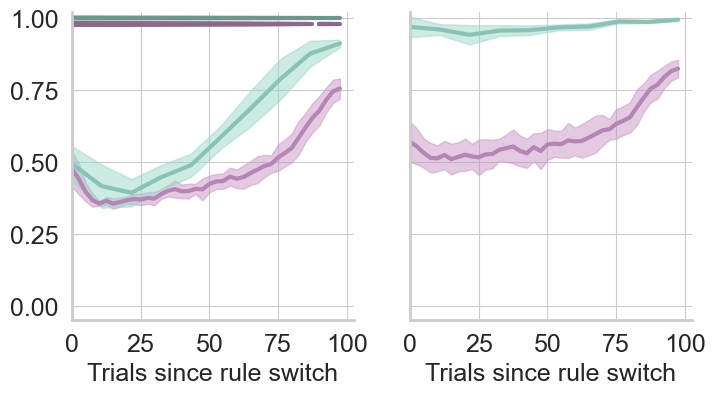

In [8]:

fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(4*2,4), sharey=True)
speciesColor = np.array([[201,148,199],[153,216,201]])/255

for pType in range(2):
    for spInd in range(2):
        if spInd == 0: # Monkeys
            probabilityPredS = probabilityPredM[:,:,pType]
            xSpecies = np.arange(40)
            sigS = sigM
        else: # Humans
            probabilityPredS = probabilityPredH[:,:,pType]
            xSpecies = np.arange(0,40,4.333333)
            sigS = sigH

        meanSpecies = np.mean(probabilityPredS,axis=1)
        stdSpecies = np.std(probabilityPredS,axis=1)

        loSpecies = meanSpecies-stdSpecies
        hiSpecies = meanSpecies+stdSpecies
        ax[pType].plot(xSpecies,meanSpecies,linewidth=3,color=speciesColor[spInd]*0.9)
        ax[pType].fill_between(xSpecies,loSpecies,hiSpecies,color=speciesColor[spInd],alpha=0.5)

        if pType == 0:
            ic = -1
            start = -1
            for i in xSpecies:
                ic = ic + 1
                if sigS[ic] < 0.05:
                    if start == -1:
                        start = i
                else:
                    if start > -1:
                        ax[pType].plot([start, i],[0.98+0.02*spInd,0.98+0.02*spInd],'-',linewidth=3,color=speciesColor[spInd]*0.7)
                        start = -1

                if start > -1:
                    ax[pType].plot([start, i],[0.98+0.02*spInd,0.98+0.02*spInd],'-',linewidth=3,color=speciesColor[spInd]*0.7)

    #######################

    # ax.set_title(subjectNames[idx],fontsize=15,y=1.05)
    ax[pType].set_xticks([0,10,20,30,40])
    ax[pType].set_yticks([0,0.25,0.5,0.75,1])
    ax[pType].set_xticklabels([0,25,50,75,100])
    ax[pType].set_ylim([-0.05,1.02])

    ax[pType].set_xlim([0,41])
    ax[pType].set_xlabel('Trials since rule switch',fontsize=18)

    ax[pType].tick_params(axis='both',labelsize= 18,direction='out',width=2, length=6)
    # change all spines
    for axis in ['top','bottom','left','right']:
        ax[pType].spines[axis].set_linewidth(2)

    ax[pType].spines['right'].set_visible(False)
    ax[pType].spines['top'].set_visible(False)

    ax[pType].set_axisbelow(True)
    # ax[pType].grid(which='major', axis='both')



# plt.subplots_adjust(wspace=0.4,
#                 hspace=0.0)
# plt.savefig('objPred.eps', format='eps')


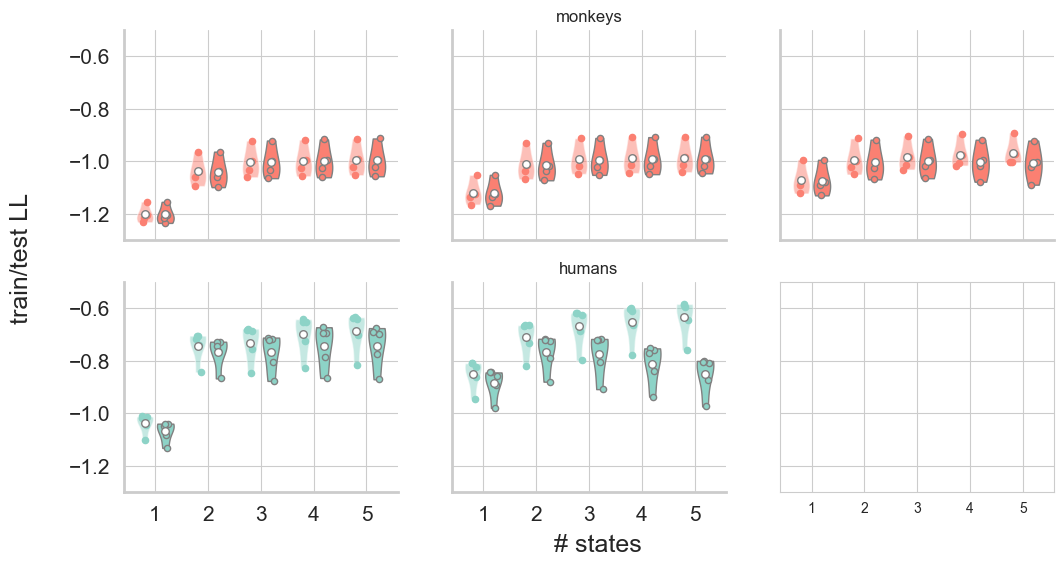

In [9]:
vpWidth = 0.35

fig, ax = plt.subplots(ncols=3,nrows=2,sharex=True,sharey=True,figsize=(3*4,3*2))

fig.text(0.52, 0.01, '# states', ha='center', size=18)
fig.text(0.03, 0.5, 'train/test LL', va='center', rotation='vertical', size=18)

for spInd in range(2): # Monkeys and first human dataset

    for lag in range(trainDat_objPred[species[spInd]].shape[0]):
        for k in range(5):
            # train
            data1 = trainDat_objPred[species[spInd]][lag,:,k]
            x1 = k+1-vpWidth/1.8
            vp1 = ax[spInd, lag].violinplot(data1,[x1],showextrema=False,widths=0.9*vpWidth)
            for pc in vp1['bodies']:
                pc.set_facecolor(speciesColors[spInd])#speciesColor[0])
#                 pc.set_edgecolor('gray')
                pc.set_alpha(0.5)

            x = npr.rand(trainDat_objPred[species[spInd]].shape[1]) * (vpWidth) * (0.2)
            pm = getPM(x.shape[0])
            x = np.multiply(x,pm) + x1
            ax[spInd, lag].scatter(x,data1,s=20,color=speciesColors[spInd])#speciesColor[0])

            ax[spInd, lag].scatter(x1,np.mean(data1),color='white',s=30,edgecolors='gray')

            # test
            data2 = testDat_objPred[species[spInd]][lag,:,k]
            x2 = k+1+vpWidth/1.8
            vp2 = ax[spInd, lag].violinplot(data2,[x2],showextrema=False,widths=0.9*vpWidth)
            for pc in vp2['bodies']:
                pc.set_facecolor(speciesColors[spInd])
                pc.set_edgecolor('gray')
                pc.set_alpha(1)

            x = npr.rand(trainDat_objPred[species[spInd]].shape[1]) * (vpWidth) * (0.2)
            pm = getPM(x.shape[0])
            x = np.multiply(x,pm) + x2
            ax[spInd, lag].scatter(x,data2,s=20,color=speciesColors[spInd],edgecolors='gray')

            ax[spInd, lag].scatter(x2,np.mean(data2),color='white',s=30,edgecolors='gray')

        ax[spInd, lag].set_ylim([-1.3,-0.5])

        ax[spInd, lag].set_axisbelow(True)
        # ax[spInd, lag].grid(which='major', axis='both')
        ax[spInd, lag].tick_params(axis='both',labelsize= 15,direction='in',pad=10)

        ax[spInd, lag].set_xticks(np.arange(5)+1)
        ax[spInd, lag].set_yticks(np.arange(-1.2,-0.5, 0.2))
        # change all spines
        for axis in ['top','bottom','left','right']:
            ax[spInd, lag].spines[axis].set_linewidth(2)

        ax[spInd, lag].spines['right'].set_visible(False)
        ax[spInd, lag].spines['top'].set_visible(False)

        # increase tick width
        ax[spInd, lag].tick_params(width=2)

    ax[spInd, 1].set_title(species[spInd])
# plt.savefig('monkeyFitStats.eps', format='eps')